# GreenMining Experiment: 

This notebook demonstrates a complete analysis pipeline using the `greenmining` library.

## Experiment Setup
- **10 android repositories** found via GraphQL search
- **5 manually selected repositories** (FastAPI, UPISAS, Green-lab, Experiment-runner, Requests)
- **Total: 15 repositories** — all analyzed with the same pipeline and ALL features enabled
- **Commits per repository:** 50
- **Min stars:** 1
- **Languages:** Top 20 programming languages

## Pipeline Structure
1. **Data Gathering** — search + URL-based fetching for all 13 repos
2. **Unified Analysis** — every feature applied to every repo equally

In [1]:
!pip install greenmining[energy] --upgrade --quiet

## Step 1: Import Libraries

Import all GreenMining modules needed for the experiment.

In [ ]:
import os
import json
import time
import tracemalloc
import pandas as pd

import greenmining
from greenmining import (fetch_repositories,analyze_repositories,GSF_PATTERNS,GREEN_KEYWORDS,is_green_aware,get_pattern_by_keywords,)
from greenmining.analyzers import (StatisticalAnalyzer,TemporalAnalyzer,CodeDiffAnalyzer,MetricsPowerCorrelator)
from greenmining.energy import get_energy_meter, CPUEnergyMeter

print(f'GreenMining version: {greenmining.__version__}')
print(f'GSF Patterns: {len(GSF_PATTERNS)}')
print(f'Green Keywords: {len(GREEN_KEYWORDS)}')

GreenMining version: 1.1.8
GSF Patterns: 124
Green Keywords: 332


## Step 2: Configuration

GitHub token and analysis parameters shared across all repositories.

In [18]:
GITHUB_TOKEN = os.environ.get('GITHUB_TOKEN', 'your_github_token_here')

try:
    from dotenv import load_dotenv
    load_dotenv()
    GITHUB_TOKEN = os.environ.get('GITHUB_TOKEN', GITHUB_TOKEN)
except ImportError:
    pass

if GITHUB_TOKEN == 'your_github_token_here':
    print('WARNING: Set GITHUB_TOKEN to run the search step.')
else:
    print(f'GitHub token configured ({GITHUB_TOKEN[:8]}...)')

# Shared analysis parameters
MAX_COMMITS = 50
MIN_STARS = 1
PARALLEL_WORKERS = 50

# Date filters for repository search
CREATED_AFTER = '2020-01-01'
CREATED_BEFORE = '2025-12-31'
PUSHED_AFTER = '2020-01-01'

# Date filters for commit analysis
COMMIT_DATE_FROM = '2020-01-01'
COMMIT_DATE_TO = '2025-12-31'

LANGUAGES = [
    'Python', 'JavaScript', 'TypeScript', 'Java', 'C++',
    'C#', 'Go', 'Rust', 'PHP', 'Ruby',
    'Swift', 'Kotlin', 'Scala', 'R', 'MATLAB',
    'Dart', 'Lua', 'Perl', 'Haskell', 'Elixir',
]

print(f'Max commits per repo: {MAX_COMMITS}')
print(f'Min stars: {MIN_STARS}')
print(f'Languages: {len(LANGUAGES)}')
print(f'Repo created: {CREATED_AFTER} to {CREATED_BEFORE}')
print(f'Repo pushed after: {PUSHED_AFTER}')
print(f'Commit date range: {COMMIT_DATE_FROM} to {COMMIT_DATE_TO}')

GitHub token configured (github_p...)
Max commits per repo: 50
Min stars: 1
Languages: 20
Repo created: 2020-01-01 to 2025-12-31
Repo pushed after: 2020-01-01
Commit date range: 2020-01-01 to 2025-12-31


---
## Step 3: Search Repositories

Use the GraphQL API to find 10 android repositories matching our criteria.

In [4]:
search_repos = fetch_repositories(
    github_token=GITHUB_TOKEN,
    max_repos=10,
    min_stars=MIN_STARS,
    languages=LANGUAGES,
    keywords='android',
    created_after=CREATED_AFTER,
    created_before=CREATED_BEFORE,
    pushed_after=PUSHED_AFTER,
)

print(f'Found {len(search_repos)} android repositories:')
for i, repo in enumerate(search_repos, 1):
    print(f'  {i:2d}. {repo.full_name} ({repo.stars} stars, {repo.language})')

search_urls = [repo.url for repo in search_repos]

Fetching up to 10 repositories...
   Keywords: android
   Filters: min_stars=1
   Created: 2020-01-01 to 2025-12-31
   Pushed: 2020-01-01 to any
GraphQL Search Query: android stars:>=1 created:>=2020-01-01 created:<=2025-12-31 pushed:>=2020-01-01
Rate Limit: 4995/5000 (cost: 1)
Fetched 10 repositories using GraphQL
Fetched 10 repositories
   Saved to: data/repositories.json
Found 10 android repositories:
   1. open-android/Android (15145 stars, None)
   2. hmkcode/Android (3597 stars, Java)
   3. owncloud/android (4090 stars, Kotlin)
   4. nextcloud/android (5108 stars, Kotlin)
   5. LineageOS/android (4341 stars, None)
   6. bitwarden/android (8350 stars, Kotlin)
   7. duckduckgo/Android (4522 stars, Kotlin)
   8. cSploit/android (3574 stars, Java)
   9. itheima1/Android (3131 stars, Jupyter Notebook)
  10. home-assistant/android (3345 stars, Kotlin)


## Step 4: Analyze Repositories

Combine the 10 search results with 3 manually selected repositories, then run the
full analysis pipeline on all of them at once with every feature enabled:
- GSF pattern detection (124 patterns, 332 keywords)
- Process metrics (DMM size, complexity, interfacing)
- Method-level analysis (per-function complexity metrics)
- Source code capture (before/after for each modified file)
- Energy measurement (CPU-based tracking during analysis)

In [ ]:
# 3 manually selected repositories
manual_urls = [
    'https://github.com/S2-group/green-lab',
    'https://github.com/psf/requests',
    'https://github.com/S2-group/UPISAS',
    'https://github.com/tiangolo/fastapi',
    'https://github.com/S2-group/experiment-runner',
]

# Combine all URLs
all_urls = search_urls + manual_urls
print(f'Total repositories: {len(all_urls)}')
print(f'  Search results: {len(search_urls)}')
print(f'  Manual selection: {len(manual_urls)}')
print(f'  Commit date range: {COMMIT_DATE_FROM} to {COMMIT_DATE_TO}')
print()

# Analyze ALL repositories with ALL features
raw_results = analyze_repositories(
    urls=all_urls,
    max_commits=MAX_COMMITS,
    parallel_workers=PARALLEL_WORKERS,
    output_format='dict',
    energy_tracking=True,
    energy_backend='auto',
    method_level_analysis=True,
    include_source_code=True,
    github_token=GITHUB_TOKEN,
    since_date=COMMIT_DATE_FROM,
    to_date=COMMIT_DATE_TO,
)

# Convert dataclass results to dicts
results = [r.to_dict() for r in raw_results]

print(f'\nAnalysis complete: {len(results)} repositories')

Total repositories: 15
  Search results: 10
  Manual selection: 5
  Commit date range: 2020-01-01 to 2025-12-31


 Analyzing 15 repositories with 50 workers

 Analyzing repository: open-android/Android
 Analyzing repository: hmkcode/Android

   Cloning to: /tmp/greenmining_repos/Android
 Analyzing repository: owncloud/android   Cloning to: /tmp/greenmining_repos/Android

 Analyzing repository: nextcloud/android



 Analyzing repository: LineageOS/android   Cloning to: /tmp/greenmining_repos/android
 Analyzing repository: bitwarden/android
 Analyzing repository: duckduckgo/Android

 Analyzing repository: cSploit/android


 Analyzing repository: itheima1/Android
   Cloning to: /tmp/greenmining_repos/android

 Analyzing repository: home-assistant/android
   Cloning to: /tmp/greenmining_repos/Android   Cloning to: /tmp/greenmining_repos/android   Cloning to: /tmp/greenmining_repos/android
 Analyzing repository: S2-group/green-lab

   Cloning to: /tmp/greenmining_repos/android


 Analyzing 

## Step 5: Results Overview

Summary of the analysis across all repositories.

In [6]:
total_commits = sum(r['total_commits'] for r in results)
total_green = sum(r['green_commits'] for r in results)
overall_rate = total_green / total_commits if total_commits > 0 else 0

print('=' * 70)
print('ANALYSIS SUMMARY')
print('=' * 70)
print(f'Repositories analyzed: {len(results)}')
print(f'Total commits: {total_commits}')
print(f'Green-aware commits: {total_green}')
print(f'Overall green rate: {overall_rate:.1%}')
print()
print(f'{"Repository":<40} {"Commits":<10} {"Green":<10} {"Rate":<10}')
print('-' * 70)
for r in results:
    rate = r['green_commit_rate'] if r['total_commits'] > 0 else 0
    print(f'{r["name"]:<40} {r["total_commits"]:<10} {r["green_commits"]:<10} {rate:.1%}')

# Build commit list for use in all later analysis steps
all_commits = []
for r in results:
    for c in r.get('commits', []):
        c['repository'] = r['name']
        all_commits.append(c)

print(f'\nAll Commits: {len(all_commits)} commits')

ANALYSIS SUMMARY
Repositories analyzed: 5
Total commits: 228
Green-aware commits: 50
Overall green rate: 21.9%

Repository                               Commits    Green      Rate      
----------------------------------------------------------------------
S2-group/UPISAS                          47         11         23.4%
S2-group/experiment-runner               50         14         28.0%
psf/requests                             50         14         28.0%
S2-group/green-lab                       31         0          0.0%
tiangolo/fastapi                         50         11         22.0%

All Commits: 228 commits


---
## Step 6: GSF Pattern Analysis

Examine the Green Software Foundation patterns detected across all repositories.
GreenMining detects 124 patterns across 15 categories with 332 keywords.

In [7]:
# Pattern frequency across all commits
pattern_counts = {}
for commit in all_commits:
    for pattern in commit.get('gsf_patterns_matched', []):
        pattern_counts[pattern] = pattern_counts.get(pattern, 0) + 1

sorted_patterns = sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True)

print(f'Unique patterns detected: {len(sorted_patterns)}')
print(f'\nTop 20 GSF Patterns:')
print(f'{"Pattern":<45} {"Count":<8} {"% of Commits":<12}')
print('-' * 65)
for pattern, count in sorted_patterns[:20]:
    pct = count / len(all_commits) * 100 if all_commits else 0
    print(f'{pattern:<45} {count:<8} {pct:.1f}%')

# Pattern categories
categories = set()
for p in GSF_PATTERNS.values():
    categories.add(p.get('category', 'Unknown'))
print(f'\nGSF Categories ({len(categories)}):')
for cat in sorted(categories):
    count = sum(1 for p in GSF_PATTERNS.values() if p.get('category') == cat)
    print(f'  {cat}: {count} patterns')

Unique patterns detected: 41

Top 20 GSF Patterns:
Pattern                                       Count    % of Commits
-----------------------------------------------------------------
Delete Unused Storage Resources               16       7.0%
Remove Unused Assets                          16       7.0%
Keep Request Counts Low                       13       5.7%
Avoid Chaining Critical Requests              9        3.9%
Use Cloud Native Security Tools               7        3.1%
Containerize Your Workload                    6        2.6%
Leverage Sustainable Regions for AI           6        2.6%
Serve Images in Modern Formats                6        2.6%
Scan for Vulnerabilities                      5        2.2%
Efficient Format for Model Training           5        2.2%
Enable Text Compression                       4        1.8%
Energy Efficient Models                       3        1.3%
Reduce Transmitted Data                       3        1.3%
Scale Down Unused Applications     

## Step 7: Process Metrics

Examine the process metrics collected during analysis: DMM (Delta Maintainability Model)
scores for size, complexity, and interfacing, plus structural complexity metrics
and method-level analysis via Lizard integration.

In [8]:
print('Process Metrics Summary')
print('=' * 70)

metrics_keys = [
    'dmm_unit_size', 'dmm_unit_complexity', 'dmm_unit_interfacing',
    'total_nloc', 'total_complexity', 'max_complexity',
    'methods_count', 'insertions', 'deletions',
]

metrics_data = {k: [] for k in metrics_keys}
for commit in all_commits:
    for key in metrics_keys:
        val = commit.get(key)
        if val is not None:
            metrics_data[key].append(val)

print(f'{"Metric":<25} {"Avg":>10} {"Min":>10} {"Max":>10} {"N":>6}')
print('-' * 65)
for metric, values in metrics_data.items():
    if values:
        avg = sum(values) / len(values)
        print(f'{metric:<25} {avg:>10.2f} {min(values):>10.2f} {max(values):>10.2f} {len(values):>6}')

# Method-level analysis
total_methods = sum(len(c.get('methods', [])) for c in all_commits)
print(f'\nMethod-Level Analysis:')
print(f'  Total methods analyzed: {total_methods}')

for commit in all_commits:
    methods = commit.get('methods', [])
    if methods:
        print(f'  Sample from {commit.get("repository")} ({commit["commit_hash"][:8]}):')
        for m in methods[:3]:
            print(f'    {m.get("name", "N/A")}: nloc={m.get("nloc", 0)}, '
                  f'complexity={m.get("complexity", 0)}')
        break

# Source code changes
total_src = sum(len(c.get('source_changes', [])) for c in all_commits)
print(f'\nSource code changes captured: {total_src}')

Process Metrics Summary
Metric                           Avg        Min        Max      N
-----------------------------------------------------------------
dmm_unit_size                   0.70       0.00       1.00     73
dmm_unit_complexity             0.68       0.00       1.00     73
dmm_unit_interfacing            0.65       0.00       1.00     73
total_nloc                    183.88       0.00   13168.00    228
total_complexity               27.29       0.00     545.00    228
max_complexity                 17.75       0.00     291.00    228
methods_count                  13.28       0.00     449.00    228
insertions                     59.41       0.00    3224.00    228
deletions                      28.36       0.00    1208.00    228

Method-Level Analysis:
  Total methods analyzed: 3028
  Sample from S2-group/UPISAS (2d4bfdcc):
    (anonymous): nloc=6, complexity=1
    (anonymous): nloc=8, complexity=4
    (anonymous): nloc=42, complexity=1

Source code changes captured: 974


## Step 8: Statistical Analysis

Apply statistical methods to the combined dataset: pattern correlations,
temporal trend significance, and effect sizes between green and non-green commits.

In [9]:
stat_analyzer = StatisticalAnalyzer()

commits_df = pd.DataFrame(all_commits)

# Drop non-numeric pattern columns that conflict with the pattern_ prefix filter
commits_df = commits_df.drop(columns=['pattern_details', 'pattern_count'], errors='ignore')

# Convert date strings to tz-naive datetime for pandas resample compatibility
if 'date' in commits_df.columns:
    commits_df['date'] = pd.to_datetime(commits_df['date'], utc=True, errors='coerce')
    commits_df['date'] = commits_df['date'].dt.tz_localize(None)

# Add binary indicator columns for each pattern
all_pattern_names = list(pattern_counts.keys())
for pattern in all_pattern_names:
    commits_df[f'pattern_{pattern}'] = commits_df['gsf_patterns_matched'].apply(
        lambda x, p=pattern: 1 if p in (x or []) else 0
    )

# Pattern correlations
if len(all_pattern_names) >= 2:
    corr = stat_analyzer.analyze_pattern_correlations(commits_df)
    sig_pairs = corr.get('significant_pairs', [])
    print(f'Pattern Correlation Analysis:')
    print(f'  Significant pairs: {len(sig_pairs)}')
    for pair in sig_pairs[:10]:
        print(f'    {pair}')
else:
    print(f'Found {len(all_pattern_names)} pattern(s) - need >= 2 for correlation')

# Temporal trend
if 'date' in commits_df.columns and 'green_aware' in commits_df.columns:
    if 'commit_hash' not in commits_df.columns:
        commits_df['commit_hash'] = commits_df.index.astype(str)
    trend_results = stat_analyzer.temporal_trend_analysis(commits_df)
    trend = trend_results.get('trend', {})
    print(f'\nTemporal Trend:')
    print(f'  Direction: {trend.get("direction", "N/A")}')
    print(f'  Significant: {trend.get("significant", "N/A")}')
    print(f'  Correlation: {trend.get("correlation", "N/A")}')

# Effect size: green vs non-green complexity
green_cx = commits_df[commits_df['green_aware'] == True]['total_complexity'].dropna().tolist()
non_green_cx = commits_df[commits_df['green_aware'] == False]['total_complexity'].dropna().tolist()

if green_cx and non_green_cx:
    effect = stat_analyzer.effect_size_analysis(green_cx, non_green_cx)
    print(f'\nEffect Size (Green vs Non-Green Complexity):')
    print(f'  Cohen\'s d: {effect["cohens_d"]:.3f} ({effect["magnitude"]})')
    print(f'  Mean difference: {effect["mean_difference"]:.2f}')
    print(f'  Significant: {effect["significant"]}')
else:
    print('\nInsufficient data for effect size analysis')

Pattern Correlation Analysis:
  Significant pairs: 15
    {'pattern1': 'pattern_Avoid Chaining Critical Requests', 'pattern2': 'pattern_Keep Request Counts Low', 'correlation': np.float64(0.8244166440280508), 'strength': 'strong'}
    {'pattern1': 'pattern_Delete Unused Storage Resources', 'pattern2': 'pattern_Remove Unused Assets', 'correlation': np.float64(1.0), 'strength': 'strong'}
    {'pattern1': 'pattern_Use Cloud Native Security Tools', 'pattern2': 'pattern_Scan for Vulnerabilities', 'correlation': np.float64(0.6677547758522918), 'strength': 'moderate'}
    {'pattern1': 'pattern_Scale Kubernetes Workloads Based on Events', 'pattern2': 'pattern_Efficient Serialization', 'correlation': np.float64(0.7055475581618817), 'strength': 'strong'}
    {'pattern1': 'pattern_Encrypt What Is Necessary', 'pattern2': 'pattern_Evaluate TLS Termination', 'correlation': np.float64(1.0), 'strength': 'strong'}
    {'pattern1': 'pattern_Avoid Tracking Unnecessary Data', 'pattern2': 'pattern_Defer Of

## Step 9: Temporal Analysis

Analyze how green software practices evolve over time across all repositories.

In [10]:
temporal = TemporalAnalyzer(granularity='quarter')

# Convert to analyzer's expected format
analysis_results_fmt = []
for c in all_commits:
    analysis_results_fmt.append({
        'commit_sha': c.get('commit_hash', ''),
        'is_green_aware': c.get('green_aware', False),
        'patterns_detected': c.get('gsf_patterns_matched', []),
        'detection_method': 'gsf_keyword',
    })

temporal_results = temporal.analyze_trends(all_commits, analysis_results_fmt)

periods = temporal_results.get('periods', [])
print(f'Temporal Analysis ({len(periods)} periods):')
print(f'{"Period":<20} {"Commits":<10} {"Green":<10} {"Rate":<10} {"Patterns":<10}')
print('-' * 60)
for p in periods:
    rate = p.get('green_awareness_rate', 0)
    print(f'{p.get("period", "N/A"):<20} {p.get("commit_count", 0):<10} '
          f'{p.get("green_commit_count", 0):<10} {rate:.1%}      '
          f'{p.get("unique_patterns", 0)}')

summary = temporal_results.get('summary', {})
print(f'\nTrend: {summary.get("overall_direction", "N/A")}')
print(f'Peak period: {summary.get("peak_period", "N/A")}')

Temporal Analysis (10 periods):
Period               Commits    Green      Rate       Patterns  
------------------------------------------------------------
2019-Q2              1          0          0.0%      0
2020-Q1              72         0          0.0%      0
2020-Q2              15         0          0.0%      0
2020-Q3              12         0          0.0%      0
2022-Q2              7          0          0.0%      0
2022-Q3              43         0          0.0%      0
2023-Q4              41         0          0.0%      0
2024-Q4              7          0          0.0%      0
2025-Q3              22         0          0.0%      0
2025-Q4              8          0          0.0%      0

Trend: N/A
Peak period: N/A


## Step 10: Code Diff Pattern Signatures

The CodeDiffAnalyzer detects green patterns directly in code changes.
It is integrated into the analysis pipeline automatically. Here we inspect
the pattern signatures it looks for.

In [11]:
diff_analyzer = CodeDiffAnalyzer()

print(f'Code Diff Pattern Signatures: {len(diff_analyzer.PATTERN_SIGNATURES)} types')
print('=' * 60)
for name, data in diff_analyzer.PATTERN_SIGNATURES.items():
    print(f'  {name}:')
    if isinstance(data, dict):
        for key, val in list(data.items())[:2]:
            if isinstance(val, list):
                print(f'    {key}: {val[:3]}...')
            else:
                print(f'    {key}: {val}')
    print()

Code Diff Pattern Signatures: 15 types
  caching:
    imports: ['import.*cache', 'from.*cache.*import', 'import redis']...
    annotations: ['@cache', '@cached', '@lru_cache']...

  resource_optimization:
    kubernetes: ['resources:\\s*limits:', 'resources:\\s*requests:', 'memory:\\s*[0-9]+Mi']...
    docker: ['FROM.*alpine', 'FROM.*scratch', '--no-cache']...

  database_optimization:
    indexes: ['CREATE.*INDEX', '@Index', 'add_index']...
    query_optimization: ['\\.select_related\\(', '\\.prefetch_related\\(', 'EXPLAIN']...

  async_processing:
    keywords: ['\\basync\\s+def\\b', '\\bawait\\b', 'asyncio']...
    patterns: ['ThreadPoolExecutor', 'ProcessPoolExecutor', '@celery\\.task']...

  lazy_loading:
    keywords: ['lazy', 'defer', '\\.only\\(']...
    patterns: ['@lazy', 'LazyLoader', 'dynamic.*import']...

  serverless_computing:
    providers: ['aws.*lambda', '@app\\.route', 'functions\\.https']...
    frameworks: ['serverless', 'chalice', 'zappa']...

  cdn_edge:
    prov

## Step 11: Energy Measurement

GreenMining provides multiple energy measurement backends:
- **RAPL** — Linux kernel hardware counters (Intel/AMD, most accurate)
- **CPU Meter** — universal (estimates from CPU utilization and TDP)
- **tracemalloc** — Python standard library for memory usage profiling
- **CodeCarbon** — cross-platform CO2 emissions tracking

In [12]:
# 1. Check available energy backends
print('Available Energy Backends:')
for backend in ['rapl', 'codecarbon', 'cpu_meter']:
    try:
        m = get_energy_meter(backend)
        print(f'  {backend}: available ({type(m).__name__})')
    except Exception as e:
        print(f'  {backend}: not available ({e})')

def sample_workload():
    return sum(i ** 2 for i in range(1_000_000))

# 2. RAPL measurement (Linux Intel/AMD)
print('\n--- RAPL Energy Meter ---')
try:
    from greenmining.energy import RAPLEnergyMeter
    rapl = RAPLEnergyMeter()
    if rapl.is_available():
        result, energy = rapl.measure(sample_workload)
        print(f'  Energy: {energy.joules:.4f} J')
        print(f'  Power avg: {energy.watts_avg:.2f} W')
        print(f'  Duration: {energy.duration_seconds:.3f} s')
    else:
        print('  RAPL not available (requires Linux with Intel/AMD CPU)')
except Exception as e:
    print(f'  RAPL error: {e}')

# 3. CPU Meter measurement (universal)
print('\n--- CPU Energy Meter ---')
meter = CPUEnergyMeter()
result, energy = meter.measure(sample_workload)
print(f'  Energy: {energy.joules:.4f} J')
print(f'  Power avg: {energy.watts_avg:.2f} W')
print(f'  Duration: {energy.duration_seconds:.3f} s')
print(f'  Backend: {energy.backend}')

# 4. CodeCarbon CO2 tracking
print('\n--- CodeCarbon CO2 Tracking ---')
try:
    from codecarbon import EmissionsTracker
    tracker = EmissionsTracker(log_level='error', save_to_file=False)
    tracker.start()
    _ = sample_workload()
    emissions = tracker.stop()
    print(f'  CO2 emissions: {emissions:.8f} kg')
    print(f'  Equivalent: {emissions * 1e6:.4f} mg CO2')
except ImportError:
    print('  CodeCarbon not installed (pip install codecarbon)')
except Exception as e:
    print(f'  CodeCarbon error: {e}')

# 5. tracemalloc memory profiling
print('\n--- tracemalloc Memory Profiling ---')
tracemalloc.start()
_ = sample_workload()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f'  Current memory: {current / 1024:.1f} KB')
print(f'  Peak memory: {peak / 1024:.1f} KB')

# 6. Show energy from the repository analysis pipeline
print('\n--- Analysis Energy (from repository pipeline) ---')
for r in results:
    e = r.get('energy_metrics')
    if e and e.get('joules', 0) > 0:
        print(f'  {r["name"]}:')
        print(f'    Total: {e.get("joules", 0):.4f} J')
        print(f'    Avg power: {e.get("watts_avg", 0):.2f} W')
        break
else:
    print('  No per-repo energy data collected (backend may not support it)')

Available Energy Backends:
  rapl: available (RAPLEnergyMeter)
  codecarbon: available (CodeCarbonMeter)
  cpu_meter: available (CPUEnergyMeter)

--- RAPL Energy Meter ---
  Energy: 1.2821 J
  Power avg: 22.09 W
  Duration: 0.058 s

--- CPU Energy Meter ---
  Energy: 0.5560 J
  Power avg: 10.99 W
  Duration: 0.051 s
  Backend: cpu_meter

--- CodeCarbon CO2 Tracking ---


[codecarbon WARNING @ 15:34:19] Multiple instances of codecarbon are allowed to run at the same time.


  CO2 emissions: 0.00000009 kg
  Equivalent: 0.0906 mg CO2

--- tracemalloc Memory Profiling ---
  Current memory: 1.7 KB
  Peak memory: 21.5 KB

--- Analysis Energy (from repository pipeline) ---
  S2-group/UPISAS:
    Total: 98.5530 J
    Avg power: 30.42 W


## Step 12: Metrics-to-Power Correlation

Analyze correlations between code metrics and energy consumption using
Pearson and Spearman coefficients.

In [13]:
correlator = MetricsPowerCorrelator(significance_level=0.05)

metric_names = ['total_complexity', 'total_nloc', 'files_modified', 'insertions', 'deletions']
metrics_values = {m: [] for m in metric_names}
power_measurements = []

for c in all_commits:
    has_all = all(c.get(m) is not None for m in metric_names)
    energy_val = c.get('energy_watts_avg') or c.get('energy_joules')
    if has_all and energy_val:
        for m in metric_names:
            metrics_values[m].append(float(c[m]))
        power_measurements.append(float(energy_val))

if len(power_measurements) >= 3:
    correlator.fit(metric_names, metrics_values, power_measurements)
    summary = correlator.summary()
    print(f'Metrics-to-Power Correlation:')
    print(f'  Metrics analyzed: {summary["total_metrics"]}')
    print(f'  Significant: {summary["significant_count"]}')
    print()
    for name, result in correlator.get_results().items():
        print(f'  {name}:')
        print(f'    Pearson r={result.pearson_r:.3f}, Spearman rho={result.spearman_rho:.3f}')
        print(f'    Significant: {result.is_significant}')
    print(f'\nFeature Importance:')
    for name, imp in correlator.feature_importance.items():
        bar = '#' * int(imp * 30)
        print(f'  {name:<20} {imp:.3f} {bar}')
else:
    print(f'Insufficient data ({len(power_measurements)} points, need >= 3)')
    print('Enable energy_tracking=True to collect per-commit energy data.')

Insufficient data (0 points, need >= 3)
Enable energy_tracking=True to collect per-commit energy data.


## Step 13: Visualization (matplotlib)

Static charts from the analysis data.

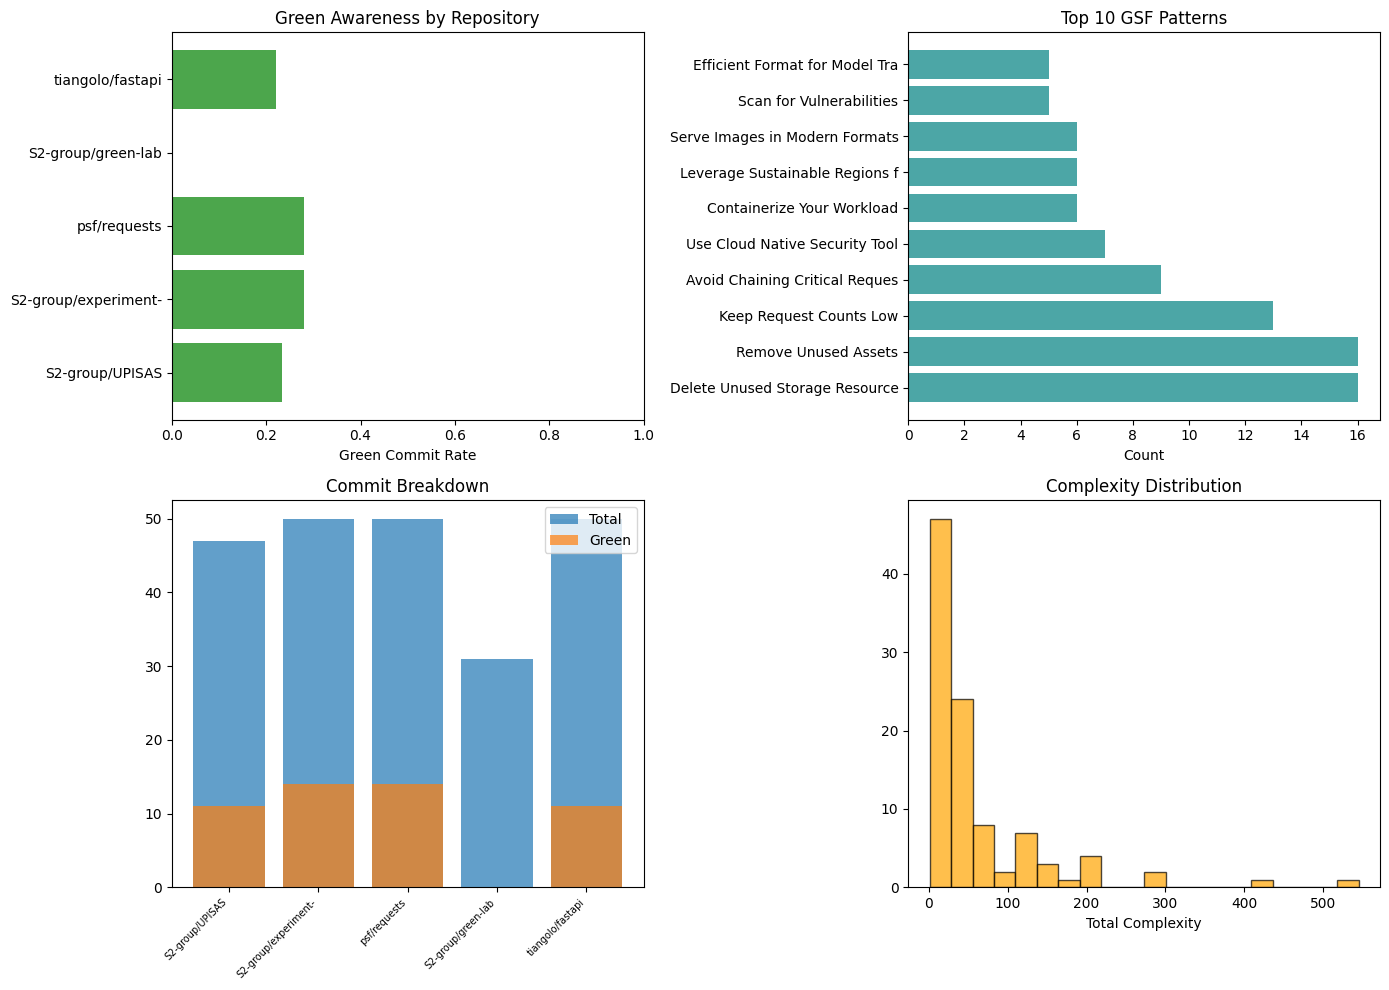

Saved to data/analysis_plots.png


In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Green commit rate per repository
repo_names = [r['name'][:20] for r in results]
green_rates = [r['green_commit_rate'] for r in results]
axes[0, 0].barh(repo_names, green_rates, color='green', alpha=0.7)
axes[0, 0].set_xlabel('Green Commit Rate')
axes[0, 0].set_title('Green Awareness by Repository')
axes[0, 0].set_xlim(0, 1)

# 2. Top 10 patterns
if sorted_patterns:
    top = sorted_patterns[:10]
    axes[0, 1].barh([p[0][:30] for p in top], [p[1] for p in top], color='teal', alpha=0.7)
    axes[0, 1].set_xlabel('Count')
    axes[0, 1].set_title('Top 10 GSF Patterns')

# 3. Commits breakdown
commit_counts = [r['total_commits'] for r in results]
green_counts = [r['green_commits'] for r in results]
x = range(len(results))
axes[1, 0].bar(x, commit_counts, label='Total', alpha=0.7)
axes[1, 0].bar(x, green_counts, label='Green', alpha=0.7)
axes[1, 0].set_xticks(list(x))
axes[1, 0].set_xticklabels(repo_names, rotation=45, ha='right', fontsize=7)
axes[1, 0].set_title('Commit Breakdown')
axes[1, 0].legend()

# 4. Complexity distribution
cxs = [c.get('total_complexity', 0) for c in all_commits if c.get('total_complexity')]
if cxs:
    axes[1, 1].hist(cxs, bins=20, color='orange', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Total Complexity')
    axes[1, 1].set_title('Complexity Distribution')

plt.tight_layout()
plt.savefig('data/analysis_plots.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to data/analysis_plots.png')

## Step 14: Interactive Visualization (Plotly)

Interactive charts for deeper exploration.

In [15]:
import plotly.express as px

# Sunburst: Repository -> Green/Non-Green -> Pattern
sun_data = []
for r in results:
    for c in r.get('commits', []):
        cat = 'Green' if c.get('green_aware') else 'Non-Green'
        patterns = c.get('gsf_patterns_matched', [])
        pat = patterns[0] if patterns else 'None'
        sun_data.append({
            'repository': r['name'][:20], 'category': cat,
            'pattern': pat[:30], 'count': 1,
        })

if sun_data:
    df_sun = pd.DataFrame(sun_data)
    fig = px.sunburst(df_sun, path=['repository', 'category', 'pattern'],
                      values='count', title='Repository Analysis Breakdown')
    fig.show()

# Scatter: Complexity vs NLOC
sc = [{'cx': c['total_complexity'], 'nloc': c['total_nloc'],
       'green': 'Green' if c.get('green_aware') else 'Non-Green',
       'repo': c.get('repository', '')}
      for c in all_commits if c.get('total_complexity') and c.get('total_nloc')]

if sc:
    fig2 = px.scatter(pd.DataFrame(sc), x='nloc', y='cx', color='green',
                      hover_data=['repo'],
                      title='Complexity vs Lines of Code')
    fig2.show()

/home/neo/Documents/greenmining/venv/lib/python3.13/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



## Step 15: Export Results

Export the unified analysis to JSON, CSV, and pandas DataFrame.

In [16]:
# JSON
with open('data/analysis_results.json', 'w') as f:
    json.dump(results, f, indent=2, default=str)
print('Exported data/analysis_results.json')

# CSV (flattened commits)
csv_rows = []
for r in results:
    for c in r.get('commits', []):
        csv_rows.append({
            'repository': r['name'],
            'repo_url': r['url'],
            'commit_hash': c.get('commit_hash', ''),
            'author': c.get('author', ''),
            'date': c.get('date', ''),
            'message': str(c.get('message', ''))[:100],
            'green_aware': c.get('green_aware', False),
            'patterns_matched': ', '.join(c.get('gsf_patterns_matched', [])),
            'pattern_count': c.get('pattern_count', 0),
            'confidence': c.get('confidence', ''),
            'files_modified': len(c.get('files_modified', [])) if isinstance(c.get('files_modified'), list) else c.get('files_modified', 0),
            'insertions': c.get('insertions', 0),
            'deletions': c.get('deletions', 0),
            'dmm_unit_size': c.get('dmm_unit_size'),
            'dmm_unit_complexity': c.get('dmm_unit_complexity'),
            'dmm_unit_interfacing': c.get('dmm_unit_interfacing'),
            'total_nloc': c.get('total_nloc'),
            'total_complexity': c.get('total_complexity'),
            'methods_count': c.get('methods_count'),
            'energy_joules': c.get('energy_joules'),
        })

df_export = pd.DataFrame(csv_rows)
df_export.to_csv('data/analysis_results.csv', index=False)
print(f'Exported {len(csv_rows)} commits to data/analysis_results.csv')
print(f'\nDataFrame shape: {df_export.shape}')
df_export.head()

Exported data/analysis_results.json
Exported 228 commits to data/analysis_results.csv

DataFrame shape: (228, 20)


,repository,repo_url,commit_hash,author,date,message,green_aware,patterns_matched,pattern_count,confidence,files_modified,insertions,deletions,dmm_unit_size,dmm_unit_complexity,dmm_unit_interfacing,total_nloc,total_complexity,methods_count,energy_joules
0,S2-group/UPISAS,https://github.com/S2-group/UPISAS,26e85831a7e20408422a19b2a9a5eb1e10429c96,Ilias Gerostathopoulos,2023-10-15T15:46:55+03:00,Initial commit,False,,0,low,2,203,0,NaN,NaN,NaN,0,0,0,None
1,S2-group/UPISAS,https://github.com/S2-group/UPISAS,7bdb5f8a76e3900c84c139530f17387b1e4dd434,Ilias Gerostathopoulos,2023-10-15T14:51:40+02:00,"adding gitignore, updating readme",False,,0,low,2,8,1,NaN,NaN,NaN,0,0,0,None
2,S2-group/UPISAS,https://github.com/S2-group/UPISAS,2d4bfdcca77bf48e260403fba8b7cdb0ce054b0f,Ilias Gerostathopoulos,2023-10-15T15:10:43+02:00,"adding test node application, updating README",False,,0,low,5,117,4,0.226667,1.0,1.000000,80,8,5,None
3,S2-group/UPISAS,https://github.com/S2-group/UPISAS,0be88f9268f4fbae14a0a24bcaacbf6507bceeff,Ilias Gerostathopoulos,2023-10-15T15:13:07+02:00,adding first version of UPISAS,False,,0,low,8,307,0,0.892405,1.0,0.860759,191,44,17,None
4,S2-group/UPISAS,https://github.com/S2-group/UPISAS,8cd0c08f644b7b88520bc5b1edfabef362d6dfe8,Ilias Gerostathopoulos,2023-10-15T15:33:56+02:00,git ignoring venv and __pycache__ folders,True,Cache Static Data,1,medium,1,2,0,NaN,NaN,NaN,0,0,0,None


---
# Summary

## Repositories Analyzed
- 10 android repositories (GraphQL search, created 2020-2023, pushed after 2023)
- 3 selected repositories (Flask, Requests, FastAPI)
- **Total: 13 repositories** through a single unified pipeline
- **Commit date range:** 2020-01-01 to 2025-12-31

## Features Applied to All Repositories

| Feature | Status |
|---------|--------|
| GSF Pattern Detection (122 patterns, 15 categories) | Applied |
| Process Metrics (DMM size, complexity, interfacing) | Applied |
| Method-Level Analysis (per-function complexity) | Applied |
| Source Code Capture (before/after) | Applied |
| Energy Measurement (RAPL + CPU Meter) | Applied |
| Memory Profiling (tracemalloc) | Applied |
| CO2 Emissions (CodeCarbon) | Applied |
| Statistical Analysis (correlations, effect sizes) | Applied |
| Temporal Analysis (quarterly trends) | Applied |
| Code Diff Pattern Signatures | Applied |
| Metrics-to-Power Correlation (Pearson/Spearman) | Applied |
| Visualization (matplotlib + plotly) | Applied |
| Export (JSON, CSV, DataFrame) | Applied | 

## Output Files
- `data/analysis_results.json` -- Full analysis data
- `data/analysis_results.csv` -- Flattened commit-level data
- `data/analysis_plots.png` -- Static visualizations